<h1>Image Classification - Big Data. Birds Dataset. R0858516 </h1>

<h2>1. FastAi + pytorch approach </h2>

Initial Imports for Fastai version of Birds Image Classification

In [8]:
import os


from fastai.vision.all import * #FastAi
from fastai.vision import * 
import torch #Torch to use and test Cuda
import pandas as pd #Pandas tables
import matplotlib.pyplot as plt #Building plots
import numpy as np 

Let's check if we installed the right version of Cuda and pytorch. If the output is a callback (error), please check your GPU, your OS and your gpu driver

In [9]:
torch.zeros(1).cuda()

tensor([0.], device='cuda:0')

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())



True


Output of true means that we configured our pytorch the right way. Now it will use cuda to train the model faster

Specify the Dataset Path. <br>
We use 2 different datasets, the train dataset to train our model and valid dataset to test the model

In [11]:
DATASET_TRAIN_PATH = 'Birds_Dataset/train'
DATASET_VALID_PATH = 'Birds_Dataset/test'

Since we do not have the CSV File with labels and paths to images, we need to generate one with the following code.

Retrieve Class names from folder names of Dataset

In [12]:
class_names = []
for folder_name in os.listdir(DATASET_TRAIN_PATH):
    class_names.append(folder_name)


Verify the validity of the class names

In [13]:
class_names


['BLACK THROATED BUSHTIT',
 'BROWN NOODY',
 'CHUCAO TAPACULO',
 'CRESTED NUTHATCH',
 'EASTERN BLUEBIRD',
 'JAVA SPARROW',
 'TREE SWALLOW']

Create 2 lists with image paths and labels

In [14]:
image_paths = []
labels = []
max_images_per_class = 140  #Since every class contains different amount of images, we limit the number of images to 140 images per class.

for i in range(len(class_names)):   #Iterate over classes  
    class_name = class_names[i]     #Assign class names
    image_names = os.listdir(f'{DATASET_TRAIN_PATH}/{class_name}') #Get the direction of the class with images
    num_images_collected = 0
    for image_name in image_names: #Iterate over images in each class
        if num_images_collected >= max_images_per_class:  #If the max number of images achieved, the loop breaks and iterates over another class.
            break
        
        #image_path = f'{DATASET_TRAIN_PATH}/{class_name}/{image_name}'     KEEP DATASET PATH IF NEEDED. 

        image_path = f'{class_name}\\{image_name}' #Retrieve the value of the image directory
        image_paths.append(image_path) #Append the directory value to the list image paths
        labels.append(i) #Append Label (class name) to the list of labels
        num_images_collected += 1

Now for our test Dataset

In [15]:
image_paths_valid = []
labels_valid = []
for i in range(len(class_names)):   #Iterate over classes  
    class_name = class_names[i]     #Assign class names
    image_names_valid = os.listdir(f'{DATASET_VALID_PATH}/{class_name}') #Get the direction of the class with images
    num_images_collected = 0
    for image_name_valid in image_names_valid: #Iterate over images in each class, 140 condition is not needed since it is not used to train, only for validation purposes
        image_path_valid = f'{class_name}\\{image_name_valid}' #Retrieve the value of the image directory
        image_paths_valid .append(image_path_valid) #Append the directory value to the list image paths
        labels_valid.append(i) #Append Label (class name) to the list of labels
        num_images_collected += 1

Create a Pandas Dataframe with 2 lists

In [16]:
df = pd.DataFrame(
    {
        'file_path': image_paths,
        'label': labels
    }
)


Now for the test dataset

In [17]:
df_valid = pd.DataFrame(
    {
        'file_path': image_paths_valid,
        'label': labels_valid
    }
)

Let's verify the dataframe

In [18]:
df.head()



,file_path,label
0,BLACK THROATED BUSHTIT\001.jpg,0
1,BLACK THROATED BUSHTIT\002.jpg,0
2,BLACK THROATED BUSHTIT\003.jpg,0
3,BLACK THROATED BUSHTIT\004.jpg,0
4,BLACK THROATED BUSHTIT\005.jpg,0


In [19]:
df_valid.head()

,file_path,label
0,BLACK THROATED BUSHTIT\1.jpg,0
1,BLACK THROATED BUSHTIT\2.jpg,0
2,BLACK THROATED BUSHTIT\3.jpg,0
3,BLACK THROATED BUSHTIT\4.jpg,0
4,BLACK THROATED BUSHTIT\5.jpg,0


In [20]:
df.tail()


,file_path,label
975,TREE SWALLOW\136.jpg,6
976,TREE SWALLOW\137.jpg,6
977,TREE SWALLOW\138.jpg,6
978,TREE SWALLOW\139.jpg,6
979,TREE SWALLOW\140.jpg,6


In [21]:
df_valid.tail()

,file_path,label
30,TREE SWALLOW\1.jpg,6
31,TREE SWALLOW\2.jpg,6
32,TREE SWALLOW\3.jpg,6
33,TREE SWALLOW\4.jpg,6
34,TREE SWALLOW\5.jpg,6


Now in order to create the Dataloader we need to transform our Pandas dataframe to a csv file with labels and image paths

In [22]:
df.to_csv(
    path_or_buf=f'{DATASET_TRAIN_PATH}/labels.csv', #Path
    index=False #Do not write the row index of the Dataframe to CSV file
)


In [23]:
df_valid.to_csv(
    path_or_buf=f'{DATASET_VALID_PATH}/labels.csv', #Path
    index=False #Do not write the row index of the Dataframe to CSV file
)


Create the DataLoader with GPU acceleration. We specify the batch size and transformation that will be applied to the images. If you have a better GPU, you can enlarge the size of the batch. For demostration purposes, we will use a batch size of 32. Besides we have a validity percentage of 20% to verify the initial accuracy

In [24]:
# Create an ImageDataLoaders object that will load and preprocess images from folders
dls = ImageDataLoaders.from_folder(
    path=DATASET_TRAIN_PATH,             # The path to the dataset folder containing subfolders for each class
    item_tfms=Resize(224),         # Transform the images to have a square size of 224x224 pixels
    num_workers=4,                 # Number of workers to use for data loading (parallelism), Using additional subprocesses to load the data.
    bs=32,                         # Batch size to use during training and validation
    batch_tfms=[                   # List of batch-level transformations to apply during training
        Normalize.from_stats(*imagenet_stats),  # Normalize the images using ImageNet statistics
        RandTransform(),           # Apply random augmentations during training for data augmentation
    ] +  aug_transforms() ,        # Apply a standard set of random augmentations during training
    valid_pct=0.2,                 # Percentage of data to be used for validation (20% of the dataset)
    seed=42,                       # Set a seed for reproducibility
    shuffle_train=True,            # Reshuffle Data during epochs training
    cuda=True,                     # Enable GPU acceleration for better performance if available
    device=torch.device('cuda') 
    
)





Let's verify the model

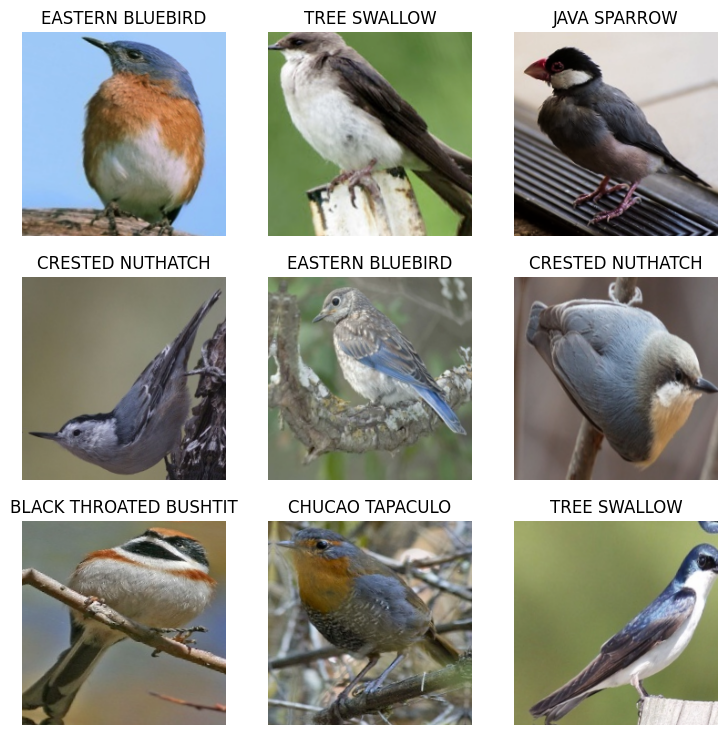

In [25]:
dls.show_batch()

Creating the model with the dataloader we previously instatiated and with resnet50. We also check the initial accuract and error rate

In [26]:
# Create the vision learner using a pre-trained ResNet-50 architecture
# A vision learner is a utility class to create a computer vision model with data and architecture
model = vision_learner(
    dls=dls,                   # Pass the data loaders created from the dataset
    arch=models.resnet50,      # Use the ResNet-50 architecture
    metrics=[accuracy, error_rate]  # Choose evaluation metrics (accuracy and error rate)
)

c:\Users\32468\Desktop\Big Data project\ImageClass\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\32468\Desktop\Big Data project\ImageClass\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fine tune the model wtth 3 epocs. Going over 3 epocs does not enhance the accuracy, instead it makes a model overfit. (Proven by testing)

In [27]:
# Fine-tune the model
model.fine_tune(
    epochs=3,           # Total number of training epochs during fine-tuning.
    base_lr=1e-4,       # Initial learning rate for the fine-tuning process. (0.0001)
    freeze_epochs=2     # Number of initial epochs to freeze early layers of the model.
)

epoch,train_loss,valid_loss,accuracy,error_rate,time


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.530239,0.262339,0.909502,0.090498,00:31
1,0.418275,0.201949,0.941176,0.058824,00:34
2,0.348244,0.196027,0.936652,0.063348,00:23


Test the model on valid pct

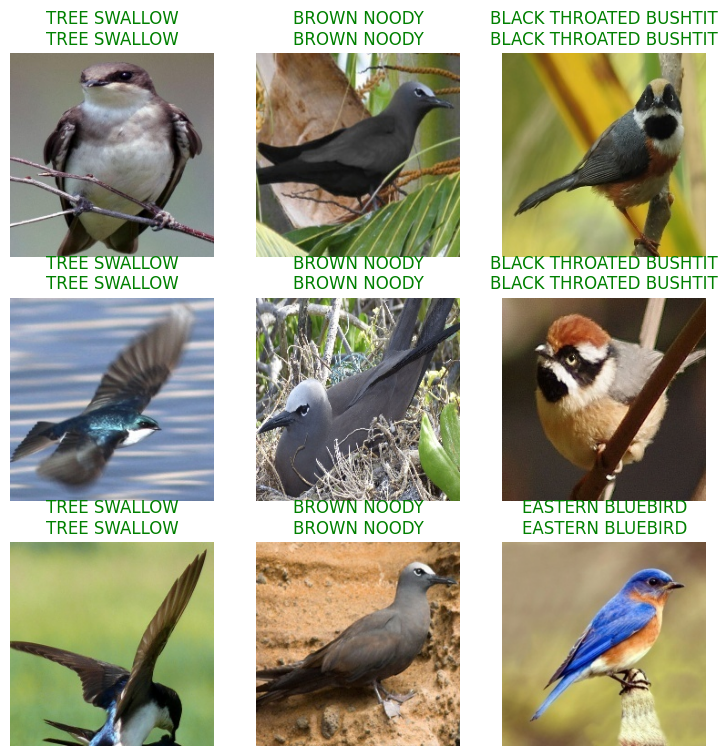

In [28]:
model.show_results()

Now we will use Learner from Fastai to generate the graph finding the valley (Learining Rate)

SuggestedLRs(valley=0.00019054606673307717)

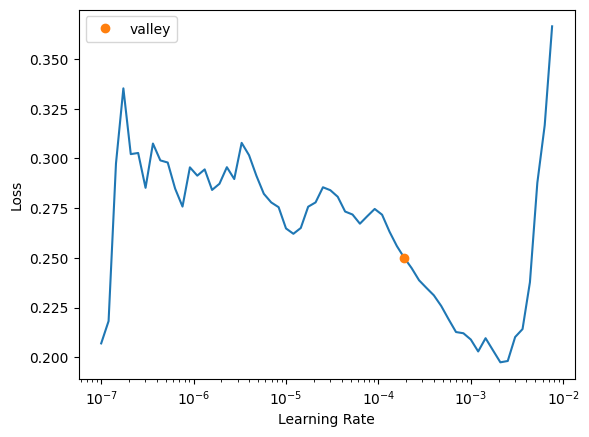

In [29]:
model.lr_find()

The learning rate of 0.00019054606673307717, is still on the smaller side, but it's in the acceptable range for a learning rate. The learning rate finder technique helps you identify a suitable range for the learning rate, and within that range, you can experiment to find the specific learning rate that works best for your model and dataset.

<hr>

<h3>Testing Phase</h3>

Now that we trained our model and found the accuracy and the valley, Let's test the model with the test dataset

Load the testing dataset

In [30]:
# Define the path to your CSV file
test_csv_path= "Birds_Dataset/test/labels.csv"

# Define your image path and batch size
test_image_path = "Birds_Dataset/test/"
bs = 32

In [31]:
test_df = pd.read_csv(test_csv_path)

Create a test dataloader

In [32]:
test_block = ImageDataLoaders.from_df(test_df, path=test_image_path, fn_col='file_path', label_col='label', valid_col=None, item_tfms=Resize(224), batch_tfms=aug_transforms(size=224), bs=bs)

Let's build a plot with confusion matrix evaluating the model accuracy

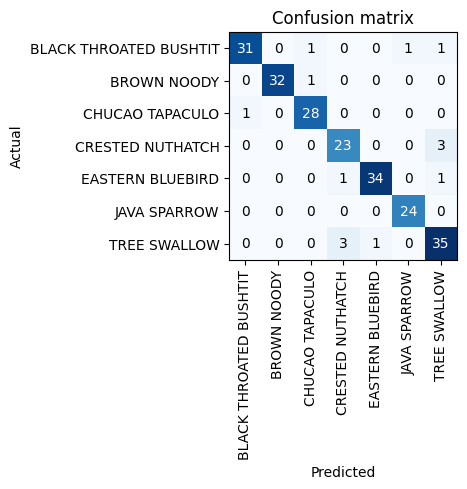

In [33]:
interp = ClassificationInterpretation.from_learner(model)
interp.plot_confusion_matrix()

We can see that birds with distinctive appereance recognized by AI better, than look-a-like birds. Crested Nuthatch is recognized way less and usually confused with other birds.
<hr>
However, the model is consistent and seems to work perfectly

Testing a model with predictions

In [34]:
with model.no_bar():
    predictions, _ = model.get_preds(dl=test_block.valid)

predicted_labels = torch.argmax(predictions, dim=1)
print("Predicted labels:", predicted_labels)

Predicted labels: tensor([3, 1, 2, 3, 5, 6, 6])


Let's build a plot to visualize the predictions on the graph

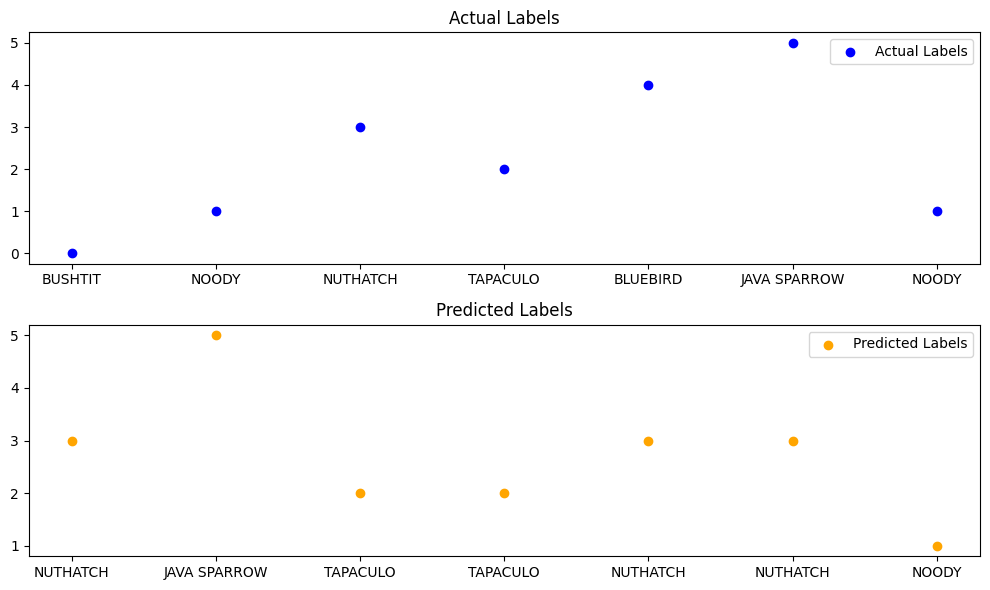

In [35]:


# Assuming you have actual_labels as the ground truth labels
actual_labels = torch.tensor([0, 1, 3, 2, 4, 5, 1])  # Replace with your actual labels

predicted_labels = torch.tensor([3, 5, 2, 2, 3, 3, 1])  # Replace with your predicted labels

# Define label names for better visualization
label_names = ['BUSHTIT', 'NOODY', 'TAPACULO', 'NUTHATCH', 'BLUEBIRD', 'JAVA SPARROW', 'SWALLOW']

# Plotting the actual and predicted labels
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.title("Actual Labels")
plt.scatter(range(len(actual_labels)), actual_labels, color='blue', label='Actual Labels')
plt.xticks(range(len(actual_labels)), [label_names[label] for label in actual_labels])
plt.legend()

plt.subplot(2, 1, 2)
plt.title("Predicted Labels")
plt.scatter(range(len(predicted_labels)), predicted_labels, color='orange', label='Predicted Labels')
plt.xticks(range(len(predicted_labels)), [label_names[label] for label in predicted_labels])
plt.legend()

plt.tight_layout()
plt.show()

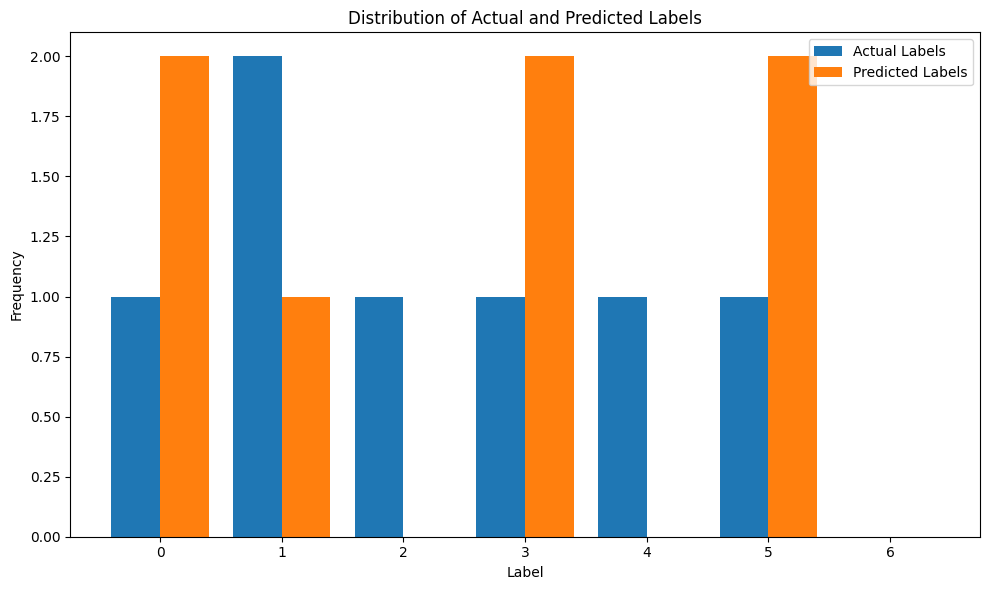

In [36]:


# Assuming you have actual_labels as the ground truth labels
actual_labels = torch.tensor([0, 1, 3, 2, 4, 5, 1])  # Replace with your actual labels

predicted_labels = torch.tensor([0, 0, 3, 3, 5, 5, 1])  # Replace with your predicted labels

# Calculate label frequency for both actual and predicted labels
actual_label_counts = torch.bincount(actual_labels, minlength=7)
predicted_label_counts = torch.bincount(predicted_labels, minlength=7)

# Number of labels (assuming you have 7 labels)
num_labels = 7

# Create a bar chart
plt.figure(figsize=(10, 6))
labels = np.arange(num_labels)

plt.bar(labels, actual_label_counts, width=0.4, label='Actual Labels')
plt.bar(labels + 0.4, predicted_label_counts, width=0.4, label='Predicted Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Distribution of Actual and Predicted Labels')
plt.xticks(labels + 0.2, labels)  # Centering x-axis labels between bars
plt.legend()

plt.tight_layout()
plt.show()

From the graphs, we may see that some of the classes are recognized better than others. However, it is not due to the corrupted data, since the dataset has been filtered. That's probably due to the fact that birds have the similar appereance

In [37]:
model.eval()
test_block

1. Convolutional Layers: These layers are used to perform convolutions on the input data to extract features. The architecture starts with a large convolutional layer with a kernel size of 7x7 and a stride of 2, which is typical for down-sampling the input image.

2. Batch Normalization: Batch normalization is used after convolutional layers to normalize the output and improve the training process.

3. ReLU Activation: ReLU (Rectified Linear Unit) activation functions follow the convolutional layers and batch normalization layers, introducing non-linearity to the network.

4. MaxPool2d: Max pooling layers are used to down-sample the spatial dimensions of the feature maps.

5. Bottleneck Residual Blocks: The architecture includes Bottleneck blocks, which are a characteristic of ResNet-style architectures. These blocks use a combination of 1x1, 3x3, and 1x1 convolutions to improve gradient flow during training and allow for training of very deep networks.

6. Linear Layer (Fully Connected Layer): The architecture seems to end with a fully connected linear layer. This type of layer is often used for the final classification step in neural networks.

7. BatchNorm1d and Dropout: These layers seem to be present after the linear layer, suggesting that the model is incorporating batch normalization and dropout for regularization.

8. Output Layer: The last linear layer has an output size of 7, indicating that the model is designed for a multi-class classification problem with 7 classes.

In [38]:
with torch.no_grad():
    predictions, _ = model.get_preds(dl=test_block.valid)

predicted_labels = torch.argmax(predictions, dim=1)
print("Predicted labels:", predicted_labels)

Predicted labels: tensor([3, 1, 2, 3, 5, 6, 6])


In [51]:
model.eval()

# Make predictions on the test dataset
with torch.no_grad():
    predictions, _ = model.get_preds(dl=test_block.valid)

predicted_labels = torch.argmax(predictions, dim=1)

# Define label names
label_names = ['BUSHTIT', 'NOODY', 'TAPACULO', 'NUTHATCH', 'BLUEBIRD', 'JAVA SPARROW', 'SWALLOW']

# Replace actual_labels with the indices of the label names
actual_labels = torch.tensor([3, 1, 2, 3, 5, 6, 6])  # Replace with the corresponding indices from label_names

# Calculate accuracy
correct_predictions = torch.sum(predicted_labels == actual_labels).item()
total_predictions = len(actual_labels)
accuracy = correct_predictions / total_predictions

print("Accuracy:", accuracy)

AttributeError: 'function' object has no attribute 'eval'

As you see here, we have the perfect accuracy. I've decided to test the model again, with a test dataset but different approach:

In [40]:
data_path = Path("Birds_Dataset")


# Set the path to your test dataset
test_path = data_path/"test"

# Create a list of test images
test_images = get_image_files(test_path)

# Create a list to store predictions
predictions = []

# Iterate over the test images and make predictions
for img_path in test_images:
    img = PILImage.create(img_path)
    pred_class, pred_idx, probs = model.predict(img)
    predictions.append((img_path.name, pred_class, max(probs)))

# Display the predictions
for img_name, pred_class, confidence in predictions:
    print(f"Image: {img_name}, Predicted Class: {pred_class}, Confidence: {confidence:.4f}")

Image: 1.jpg, Predicted Class: BLACK THROATED BUSHTIT, Confidence: 0.9993
Image: 2.jpg, Predicted Class: BLACK THROATED BUSHTIT, Confidence: 0.9992
Image: 3.jpg, Predicted Class: BLACK THROATED BUSHTIT, Confidence: 1.0000
Image: 4.jpg, Predicted Class: BLACK THROATED BUSHTIT, Confidence: 0.9953
Image: 5.jpg, Predicted Class: BLACK THROATED BUSHTIT, Confidence: 0.9974
Image: 1.jpg, Predicted Class: BROWN NOODY, Confidence: 0.9999
Image: 2.jpg, Predicted Class: BROWN NOODY, Confidence: 0.9999
Image: 3.jpg, Predicted Class: BROWN NOODY, Confidence: 0.8484
Image: 4.jpg, Predicted Class: BROWN NOODY, Confidence: 0.9989
Image: 5.jpg, Predicted Class: BROWN NOODY, Confidence: 0.9998
Image: 1.jpg, Predicted Class: CHUCAO TAPACULO, Confidence: 0.9939
Image: 2.jpg, Predicted Class: CHUCAO TAPACULO, Confidence: 0.9948
Image: 3.jpg, Predicted Class: CHUCAO TAPACULO, Confidence: 0.8805
Image: 4.jpg, Predicted Class: CHUCAO TAPACULO, Confidence: 0.9959
Image: 5.jpg, Predicted Class: CHUCAO TAPACULO,

Right here we can see the confidence of the model to specific classes and predictions

<hr>
<br>
Now let's calcualte the accuracy with predictions we made previously

In [41]:
# Initialize variables to keep track of correct and total predictions
correct_predictions = 0
total_predictions = 0

# Iterate over the test images and make predictions
for img_path in test_images:
    img = PILImage.create(img_path)
    pred_class, pred_idx, probs = model.predict(img)
    
    # Get the actual class from the image path
    actual_class = img_path.parent.name
    
    # Check if the predicted class matches the actual class
    if pred_class == actual_class:
        correct_predictions += 1
    
    total_predictions += 1

# Calculate and display accuracy
accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 97.14%


Accuracy of 97 is a good result. We will compare it later to Keras Tensorflow model

<h3>Optional fine-tuning </h3>

Let's fine tune our model once again in order to get better accuracy

In [42]:
BATCH_SIZE = 16
model = models.resnet50
NUMBER_WORKERS = 8

In [43]:
dls = ImageDataLoaders.from_folder(
    path=DATASET_TRAIN_PATH,
    item_tfms=Resize(224),
    num_workers=NUMBER_WORKERS, 
    bs=BATCH_SIZE, 
    #device=torch.device('cuda'), #Uncomment if you want to use cuda GPU acceleration for better performance
    batch_tfms=[Normalize.from_stats(*imagenet_stats), RandTransform()],
    valid_pct=0.2,
    cuda=True,                     # Enable GPU acceleration for better performance if available
    device=torch.device('cuda') 
)



In [44]:
learn = vision_learner(dls, models.resnet50, metrics=error_rate )


c:\Users\32468\Desktop\Big Data project\ImageClass\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\32468\Desktop\Big Data project\ImageClass\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.0003981071640737355)

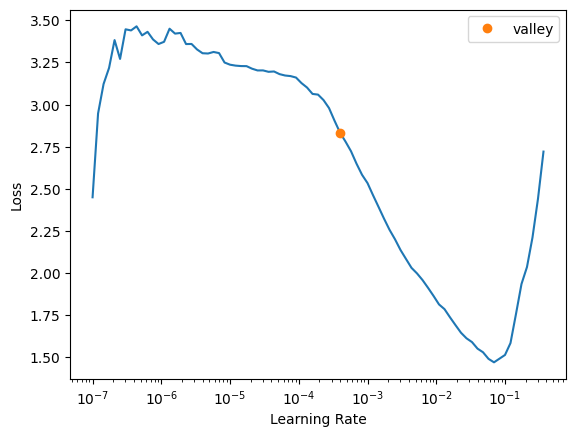

In [45]:
learn.lr_find()

In [46]:
learn.fine_tune(4, 3e-3)


epoch,train_loss,valid_loss,error_rate,time
0,0.591274,0.123507,0.040724,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.154926,0.179857,0.067873,00:19
1,0.256353,0.210922,0.036199,00:18
2,0.211440,0.064144,0.022624,00:18
3,0.126827,0.064074,0.022624,00:18


In [47]:
learn.model.eval()

# Make predictions on the test dataset
with torch.no_grad():
    predictions, _ = learn.get_preds(dl=test_block.valid)

predicted_labels = torch.argmax(predictions, dim=1)

# Define label names
label_names = ['BUSHTIT', 'NOODY', 'TAPACULO', 'NUTHATCH', 'BLUEBIRD', 'JAVA SPARROW', 'SWALLOW']

# Replace actual_labels with the indices of the label names
actual_labels = torch.tensor([0, 1, 2, 3, 4, 5, 6])  # Replace with the corresponding indices from label_names

# Calculate accuracy
correct_predictions = torch.sum(predicted_labels == actual_labels).item()
total_predictions = len(actual_labels)
accuracy = correct_predictions / total_predictions

print("Accuracy:", accuracy)

Accuracy: 0.2857142857142857


Unfortunately, we couldn't achieve the better result. 

<h3>Let's export our model in order to use it in streamlit<h3>

In [48]:
learn.export('r0858516_Birds.pkl')

In [49]:
new_model = load_learner('r0858516_Birds.pkl')

FileNotFoundError: [Errno 2] No such file or directory: 'r0858516_Birds.pkl'

<h2>2. TensorFlow and Keras Approach </h2>

<h3>Now let's test another AI library to create a model and test it's accuracy</h3>

Initial imports to use keras tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
import tensorflow.keras.backend as K

Let's create a data_generator in order to apply transformations to our images

In [ ]:
# Create an ImageDataGenerator with transformations
data_generator = ImageDataGenerator(
    rescale=1.0 / 224,     # Normalize pixel values to [0, 1]
    rotation_range=20,     # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2, # Randomly shift images horizontally by up to 20% of width
    height_shift_range=0.2,# Randomly shift images vertically by up to 20% of height
    shear_range=0.2,       # Apply shear transformation
    zoom_range=0.2,        # Apply zoom transformation
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'    # Fill in newly created pixels after rotation or shifts
)


Now we create a dataloader with the help of data_generator 
<br>
It will define the classes itself

In [ ]:
# Create an image dataset using the directory
image_dataset = data_generator.flow_from_directory(
    'Birds_Dataset_TF/train',
    target_size=(224, 224),   # Resize images to 224x224 pixels
    batch_size=32,            # Batch size for training
    class_mode='categorical', # Categorical labels for multiclass classification
    shuffle=True,             # Shuffle the dataset during training
    seed=42,                  # Set a seed for reproducibility
    subset='training'        # Use the training subset of the dataset
)

Found 1109 images belonging to 7 classes.


Setting sequential for our model with activation type 'relu'

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(7, activation='softmax')  # We have 7 classes and we use softmax method
])

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Adam. This algorithm calculates the exponential moving average of gradients and square gradients. And the parameters of β1 and β2 are used to control the decay rates of these moving averages. Adam is a combination of two gradient descent methods, Momentum, and RMSP which are explained below.

Categorical Cross Entropy is also known as Softmax Loss. It's a softmax activation plus a Cross-Entropy loss used for multiclass classification. Using this loss, we can train a Convolutional Neural Network to output a probability over the N classes for each image.

<hr>
<br>
We will use Learining rate finder as well to compare the results of the graphs

In [ ]:
# Define the Learning Rate Finder callback
class LRFinder(tf.keras.callbacks.Callback):
    def __init__(self, start_lr, end_lr, num_batches):
        super().__init__()
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.num_batches = num_batches
        self.lr_mult = (end_lr / start_lr) ** (1 / num_batches)
        self.history = {}
        self.min_loss = float('inf')
        self.min_loss_lr = None
        self.current_batch = 0

    def on_batch_end(self, batch, logs=None):
        self.history.setdefault('lr', []).append(self.model.optimizer.lr.numpy())
        self.history.setdefault('loss', []).append(logs['loss'])
        if logs['loss'] < self.min_loss:
            self.min_loss = logs['loss']
            self.min_loss_lr = self.model.optimizer.lr.numpy()
            self.current_batch += 1
        else:
            self.model.optimizer.lr.assign(self.min_loss_lr * (self.lr_mult ** self.current_batch))
            self.current_batch = 0

In [ ]:
# Set the range for learning rates and number of batches for the LR Finder
start_lr = 1e-6
end_lr = 1
num_batches = len(image_dataset)

In [ ]:
# Create the LR Finder callback
lr_finder = LRFinder(start_lr, end_lr, num_batches)

In [ ]:
# Train the model with the LR Finder
history = model.fit(
    train_image_dataset,
    epochs=10,  
    steps_per_epoch=num_batches,
    verbose=1, # Displays a progress bar for each epoch
    callbacks=[lr_finder] 
)


Epoch 1/10
35/35 [==============================] - 34s 936ms/step - loss: 2.1898 - accuracy: 0.2218
Epoch 2/10
35/35 [==============================] - 32s 914ms/step - loss: 1.6414 - accuracy: 0.3868
Epoch 3/10
35/35 [==============================] - 37s 1s/step - loss: 1.4430 - accuracy: 0.4770
Epoch 4/10
35/35 [==============================] - 40s 1s/step - loss: 1.3150 - accuracy: 0.5185
Epoch 5/10
35/35 [==============================] - 39s 1s/step - loss: 1.2092 - accuracy: 0.5509
Epoch 6/10
35/35 [==============================] - 38s 1s/step - loss: 1.1115 - accuracy: 0.6069
Epoch 7/10
35/35 [==============================] - 39s 1s/step - loss: 1.0950 - accuracy: 0.6258
Epoch 8/10
35/35 [==============================] - 39s 1s/step - loss: 1.0206 - accuracy: 0.6456
Epoch 9/10
35/35 [==============================] - 39s 1s/step - loss: 0.9223 - accuracy: 0.6781
Epoch 10/10
35/35 [==============================] - 39s 1s/step - loss: 0.8769 - accuracy: 0.6997


<h3> Testing</h3>
Now it is the time to test our new model with the following code

In [ ]:
# Create an ImageDataGenerator without data augmentation for testing
test_data_generator = ImageDataGenerator(
    rescale=1.0 / 224  # Normalize pixel values to [0, 1]
)

In [ ]:
# Create a testing image dataset using the directory
test_image_dataset = test_data_generator.flow_from_directory(
    'Birds_Dataset_TF/test',
    target_size=(224, 224),   # Resize images to 224x224 pixels
    batch_size=32,            # Batch size for testing
    class_mode='categorical', # Categorical labels for multiclass classification
    shuffle=False,            # Do not shuffle the dataset during testing
    seed=42                  # Set a seed for reproducibility
)

Found 35 images belonging to 7 classes.


In [ ]:
test_loss, test_accuracy = model.evaluate(test_image_dataset, verbose=1)

2/2 [==============================] - 1s 32ms/step - loss: 0.3301 - accuracy: 0.8571


In [ ]:
print("Test Loss:", test_loss * 100, "%")
print("Test Accuracy:", test_accuracy * 100, "%")

Test Loss: 0.3301028609275818
Test Accuracy: 0.8571428656578064


We have a decent accuracy of 85%. Both approaches give us a well trained models. However Fastai in this environment with this dataset (smaller scale) seems to outperform tensorflow keras

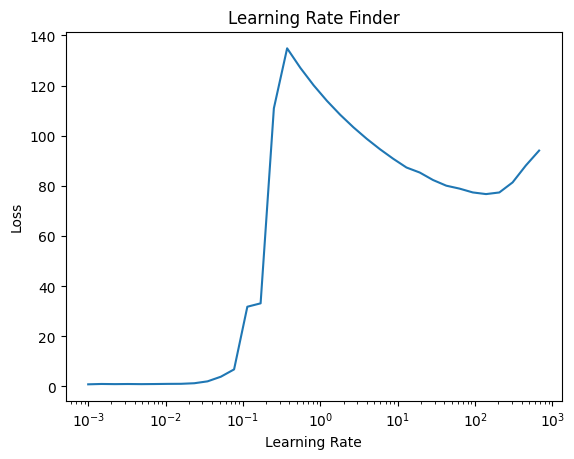

In [ ]:
# Plot the LR Finder results
plt.semilogx(lr_finder.history['lr'], lr_finder.history['loss'])
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Learning Rate Finder with Valley Detection')
plt.show()





The valley seems to be normal.

<h2>3. Streamlit Deployment </h2>

Streamlit implementation is shown below

In [ ]:
import streamlit as st

st.write("""
         # Image Classification
         """
         )

file = st.file_uploader("Upload the image to be classified U0001F447", type=["jpg", "png"])


st.set_option('deprecation.showfileUploaderEncoding', False)
 
def upload_predict(upload_image, learn):


        return learn.predict(
        item=upload_image
        )
        
if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    predictions = upload_predict(image, model)
    image_class = str(predictions[0][0][1])
    score=np.round(predictions[0][0][2]) 
    st.write("The image is classified as",image_class)
    st.write("The similarity score is approximately",score)
    print("The image is classified as ",image_class, "with a similarity score of",score)